# TCDS17 - Gil LAIFER (028482636) - Modeling exercise

## General Instructions

* Submission date: 25.4.2022
* Submission Method: Link to your solution notebook in [this sheet](https://docs.google.com/spreadsheets/d/1fTmjiVxzw_rM1hdh16enwUTtxzlHSJIiw41dJS2LKp0/edit?usp=sharing).

In [254]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
import sys; sys.path.append('../Modles and Modeling/src')
import numpy as np
import plotly_express as px

In [256]:
import pandas as pd
import ipywidgets as widgets

In [257]:
from datasets import make_circles_dataframe, make_moons_dataframe

## Fitting and Overfiting 

The goal of the following exercise is to:
* Observe overfitting due to insuffient data
* Observe Overfitting due to overly complex model
* Identify the overfitting point by looking at Train vs Test error dynamic
* Observe how noise levels effect the needed data samples and model capacity

To do so, you'll code an experiment in the first part, and analyze the experiment result in the second part.

### Building an experiment

Code:

1. Create data of size N with noise level of magnitude NL from datasets DS_NAME. 
1. Split it to training and validation data (no need for test set), use 80%-20%. 
1. Use Logistic regression and Choose one complex model of your choice: [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [SVM with RBF kernel](https://scikit-learn.org/stable/modules/svm.html) with different `gamma` values or [Random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with differnt number of `min_samples_split`. 
1. Train on the train set for different hyper parameter values. compute:
   1. Classification accuracy on the training set (TRE)
   1. Classification accuracy on the validation set (TESTE)
   1. The difference beteen the two above (E_DIFF)
1. Save DS_NAME, N, NL, CLF_NAME, K, TRE, TESTE, E_DIFF and the regularization/hyper param (K, gamma or min_samples_split and regularization value for the linear regression classifier)

Repeat for:
* DS_NAME in Moons, Circles
* N (number of samples) in [5, 10, 50, 100, 1000, 10000]
* NL (noise level) in [0, 0.1, 0.2, 0.3, 0.4, 0.5]
* For the complex model: 10 Values of hyper parameter of the complex model you've chosen.
* For the linear model: 5 values of ridge (l2) regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]

#### 1. Create data of size N with noise level of magnitude NL from datasets DS_NAME.

In [258]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [259]:
all_circles_df = []
column_names = ['dataset_name','noise_level', 'x','y','label']
for nl in noise_levels:
    circles_df = make_circles_dataframe(n_samples=10000, noise_level=nl)
    circles_df['dataset_name'] = 'circles'
    circles_df['noise_level'] = nl
    all_circles_df.append(circles_df)

circles_df = pd.concat(all_circles_df, ignore_index=True)
circles_df = circles_df.reindex(columns=column_names)

In [485]:
circles_df.sample(5)

,x,y,label
5311,-0.184211,0.570343,B
8842,-0.032911,0.376064,B
4299,-0.815430,0.983974,A
6999,-0.467355,0.244323,B
3746,-0.291617,-0.585719,B


In [261]:
all_moons_df = []
for nl in noise_levels:
    moons_df = make_moons_dataframe(n_samples=10000, noise_level=nl)
    moons_df['dataset_name'] = 'moons'
    moons_df['noise_level'] = nl
    all_moons_df.append(moons_df)

moons_df = pd.concat(all_moons_df, ignore_index=True)
moons_df = moons_df.reindex(columns=column_names)

In [262]:
moons_df.sample(5)

,dataset_name,noise_level,x,y,label
36276,moons,0.3,0.706260,0.465989,A
26840,moons,0.2,0.381984,-0.633017,B
27539,moons,0.2,0.182061,-0.068154,B
37422,moons,0.3,1.562797,0.090133,B
34328,moons,0.3,1.022972,0.976867,A


In [263]:
datasets = pd.concat([moons_df, circles_df], ignore_index=True)

In [264]:
datasets.groupby(['dataset_name','noise_level']).size() 

dataset_name  noise_level
circles       0.0            10000
              0.1            10000
              0.2            10000
              0.3            10000
              0.4            10000
              0.5            10000
moons         0.0            10000
              0.1            10000
              0.2            10000
              0.3            10000
              0.4            10000
              0.5            10000
dtype: int64

#### 2-4 Training SVM and LogReg models with different data sizes and noise levels

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [266]:
from sklearn.linear_model import LogisticRegression

In [267]:
from sklearn import svm

In [268]:
datasets_type = ['circles', 'moons']
k_folds = 10
n_samples = [10, 50, 100, 1000, 10000]
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
clf_types = ['log_reg', 'svm']
#SVM hyper parameters ranges:
C_range = [1e-2, 1e-1, 1, 1e1, 1e2]
gamma_range = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
#Log regrission regularization_values:
C_range = [1e-2, 1e-1, 1, 1e1, 1e2]

results = []
for ds_type in datasets_type:
    print(f'Working on {ds_type}')
    for nl in noise_levels:
        for n in n_samples:
            ds = datasets.query("dataset_name == @ds_type & noise_level == @nl").head(n)
            print(f'Starting {k_folds}-fold cross validation for {ds_type} dataset with {n} samples and noise level {nl}. Going to train {clf_types} classifiers.')
            kf=KFold(n_splits=k_folds)
            X, Y = ds[['x', 'y']], ds.label             
            for clf_type in clf_types:
                if clf_type == 'log_reg':
                    for regularization_value in C_range:
                        logreg=LogisticRegression(max_iter=1000)
                        score=cross_val_score(logreg,X,Y,cv=kf)
                        results.append((ds_type, nl, n, clf_type, float("nan"), regularization_value, "{:.4f}".format(score.mean()), "{:.4f}".format(score.std())))
                if clf_type == 'svm':
                    for gamma in gamma_range:
                        clf_svm = svm.SVC(C=1, gamma=gamma)
                        score=cross_val_score(clf_svm,X,Y,cv=kf)
                        results.append((ds_type, nl, n, clf_type, gamma, 1, "{:.4f}".format(score.mean()), "{:.4f}".format(score.std())))

Working on circles
Starting 10-fold cross validation for circles dataset with 10 samples and noise level 0. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 50 samples and noise level 0. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 100 samples and noise level 0. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 1000 samples and noise level 0. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 10000 samples and noise level 0. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 10 samples and noise level 0.1. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cross validation for circles dataset with 50 samples and noise level 0.1. Going to train ['log_reg', 'svm'] classifiers.
Starting 10-fold cr

In [269]:
results

[('circles', 0, 10, 'log_reg', nan, 0.01, '0.4000', '0.4899'),
 ('circles', 0, 10, 'log_reg', nan, 0.1, '0.4000', '0.4899'),
 ('circles', 0, 10, 'log_reg', nan, 1, '0.4000', '0.4899'),
 ('circles', 0, 10, 'log_reg', nan, 10.0, '0.4000', '0.4899'),
 ('circles', 0, 10, 'log_reg', nan, 100.0, '0.4000', '0.4899'),
 ('circles', 0, 10, 'svm', 0.001, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 0.01, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 0.1, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 1, 1, '0.4000', '0.4899'),
 ('circles', 0, 10, 'svm', 10.0, 1, '0.7000', '0.4583'),
 ('circles', 0, 10, 'svm', 100.0, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 1000.0, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 10000.0, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 100000.0, 1, '0.6000', '0.4899'),
 ('circles', 0, 10, 'svm', 1000000.0, 1, '0.6000', '0.4899'),
 ('circles', 0, 50, 'log_reg', nan, 0.01, '0.5200', '0.1600'),
 ('circles', 0, 50, 'log_reg', nan, 0.1, '0

#### 5 Saving the results in a file

In [270]:
results_df = pd.DataFrame(results)
results_df.columns = ['dataset_name', 'nl', 'n', 'clf', 'svm_gamma', 'reg', 'acc_mean', 'acc_std']
results_df.to_csv('results_df.csv', index=False)

In [513]:
results_df = pd.read_csv('results_df.csv')
results_df

,dataset_name,nl,n,clf,svm_gamma,reg,acc_mean,acc_std
0,circles,0.0,10,log_reg,NaN,0.01,0.4000,0.4899
1,circles,0.0,10,log_reg,NaN,0.10,0.4000,0.4899
2,circles,0.0,10,log_reg,NaN,1.00,0.4000,0.4899
3,circles,0.0,10,log_reg,NaN,10.00,0.4000,0.4899
4,circles,0.0,10,log_reg,NaN,100.00,0.4000,0.4899
...,...,...,...,...,...,...,...,...
895,moons,0.5,10000,svm,100.0,1.00,0.8218,0.0067
896,moons,0.5,10000,svm,1000.0,1.00,0.7776,0.0065
897,moons,0.5,10000,svm,10000.0,1.00,0.6675,0.0146
898,moons,0.5,10000,svm,100000.0,1.00,0.5176,0.0075


    dataset_name   nl      n  clf    svm_gamma  reg  acc_mean  acc_std
5        circles  0.0     10  svm        0.001  1.0    0.6000   0.4899
6        circles  0.0     10  svm        0.010  1.0    0.6000   0.4899
7        circles  0.0     10  svm        0.100  1.0    0.6000   0.4899
8        circles  0.0     10  svm        1.000  1.0    0.4000   0.4899
9        circles  0.0     10  svm       10.000  1.0    0.7000   0.4583
..           ...  ...    ...  ...          ...  ...       ...      ...
445      circles  0.5  10000  svm      100.000  1.0    0.5503   0.0110
446      circles  0.5  10000  svm     1000.000  1.0    0.5385   0.0140
447      circles  0.5  10000  svm    10000.000  1.0    0.5364   0.0135
448      circles  0.5  10000  svm   100000.000  1.0    0.4972   0.0136
449      circles  0.5  10000  svm  1000000.000  1.0    0.4918   0.0058

[300 rows x 8 columns]


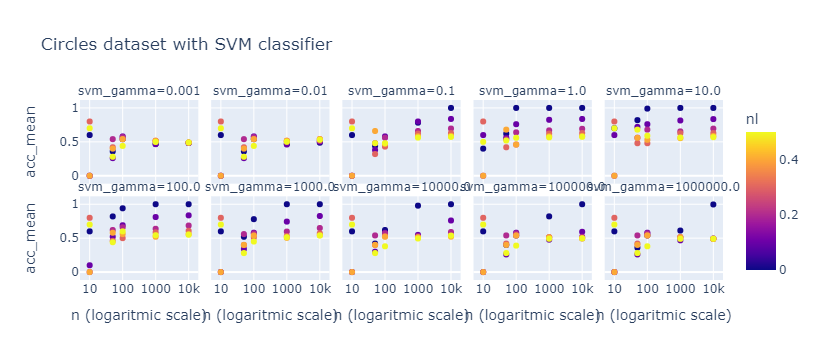

In [514]:
circles_df = results_df.query("dataset_name == 'circles' & clf == 'svm'")
print(circles_df)
px.scatter(circles_df, x='n', labels = {'n': 'n (logaritmic scale)'}, y='acc_mean', 
           facet_col='svm_gamma', facet_col_wrap=5,
           hover_data=['svm_gamma'], color='nl', 
           log_x=True, title="Circles dataset with SVM classifier")

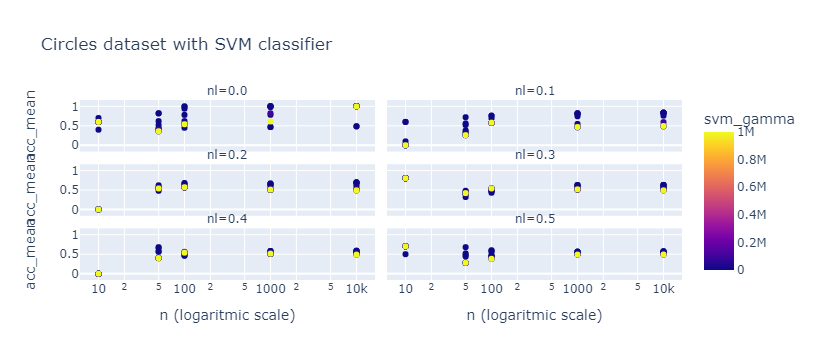

In [515]:
px.scatter(circles_df, x='n', labels = {'n': 'n (logaritmic scale)'}, y='acc_mean', 
           facet_col='nl', facet_col_wrap=2,
           hover_data=['svm_gamma'], color='svm_gamma', 
           log_x=True, title="Circles dataset with SVM classifier")

### Analysing the expermient results

1. For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it? 
1. For SVM only, For dataset of size 10k and for each dataset, What is the most stable model and model params? How good is it in comparison to other models? Explain using bias and variance terminoligy.
1. Does regularization help for linear models? consider different datasets sizes. 
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? (answer for svm and LR seperatly)
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? (answer for svm and LR seperatly)
1. Are the noise level effect the number of datapoints needed to reach optimal test results? 

#### 1. For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it? 

In [516]:
circles_df = results_df.query("dataset_name == 'circles' & clf == 'svm' & n == 10000")

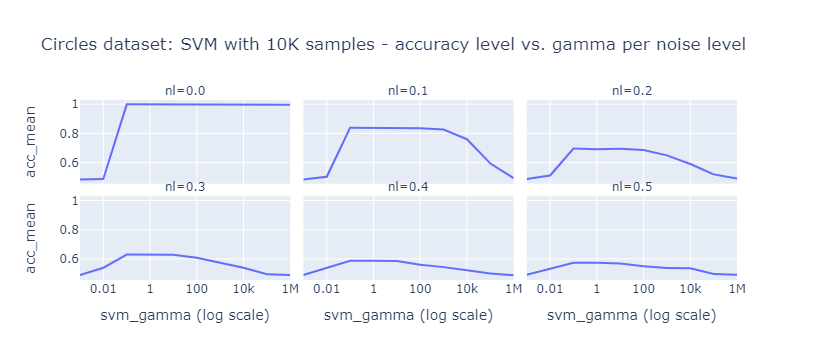

In [520]:
svm_10k_df = circles_df.groupby(['nl', 'svm_gamma']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.line(svm_10k_df, x='svm_gamma', labels = {'svm_gamma': 'svm_gamma (log scale)'}, y='acc_mean', 
           facet_col='nl', facet_col_wrap=3,
           log_x=True, title="Circles dataset: SVM with 10K samples - accuracy level vs. gamma per noise level")

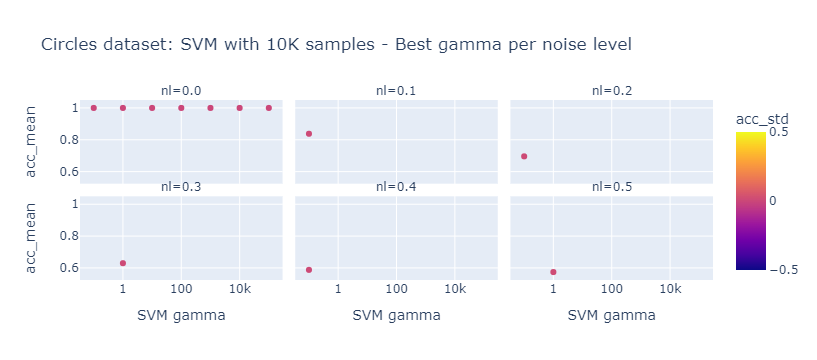

In [521]:
best_gamma_per_nl_10K_df = circles_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.scatter(best_gamma_per_nl_10K_df, x='svm_gamma', labels = {'svm_gamma': 'SVM gamma'}, y='acc_mean', 
           log_x=True,
           color = 'acc_std',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Circles dataset: SVM with 10K samples - Best gamma per noise level")

For the Circles dataset, the best model parameter (gamma) is different for each noise level:
- nl = 0: any value of gamma from 0.1 and higher delivers the highest possible accuracy level (1)
- nl = 0.1: gamma=0.1, max acc is 0.8378
- nl = 0.2: gamma=0.1, max acc is 0.6959
- nl = 0.3: gamma=1, max acc is 0.6297
- nl = 0.4: gamma=0.1, max acc is 0.5878
- nl = 0.5: gamma=1, max acc is 0.574
<br>The model is stable with standard deviation <0.018.
<br>The perfromance (accuracy level) of the model degrades as the noise level increases.

In [524]:
moons_df = results_df.query("dataset_name == 'moons' & clf == 'svm' & n == 10000")

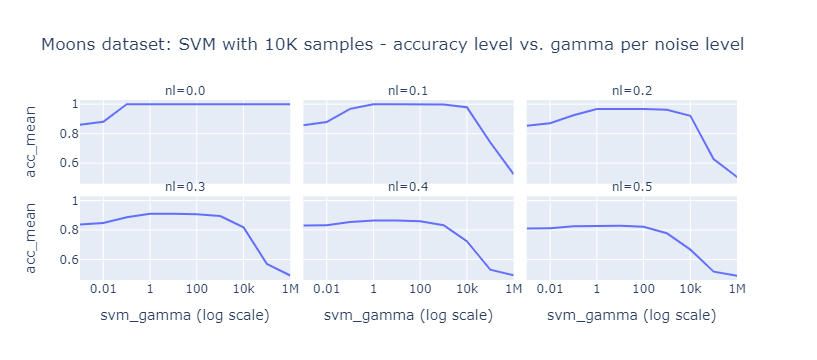

In [525]:
svm_10k_df = moons_df.groupby(['nl', 'svm_gamma']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.line(svm_10k_df, x='svm_gamma', labels = {'svm_gamma': 'svm_gamma (log scale)'}, y='acc_mean', 
           facet_col='nl', facet_col_wrap=3,
           log_x=True, title="Moons dataset: SVM with 10K samples - accuracy level vs. gamma per noise level")

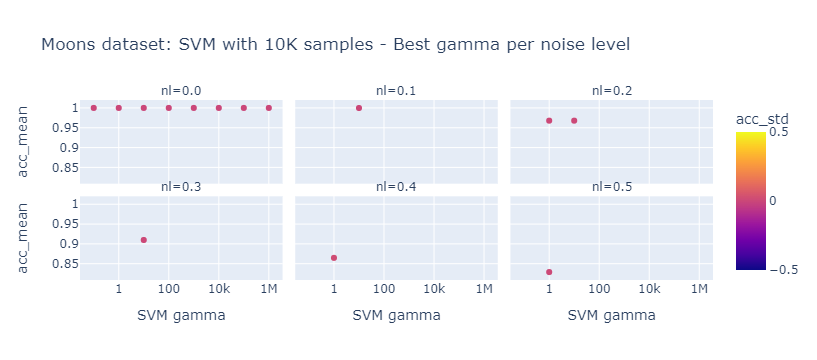

In [526]:
best_gamma_per_nl_10K_df = moons_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.scatter(best_gamma_per_nl_10K_df, x='svm_gamma', labels = {'svm_gamma': 'SVM gamma'}, y='acc_mean', 
           log_x=True,
           color = 'acc_std',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Moons dataset: SVM with 10K samples - Best gamma per noise level")

Also for the Moons dataset, the best model parameter (gamma) is different for each noise level:
* nl = 0: any value of gamma 0.1 and higher delivers the highest possible accuracy level (1)
* nl = 0.1: gamma=10, max acc is 0.9998
* nl = 0.2: gamma=1 or 10, max acc is 0.9679
* nl = 0.3: gamma=10, max acc is 0.9098
* nl = 0.4: gamma=1, max acc is 0.8647
* nl = 0.5: gamma=1, max acc is 0.8289
<br>The model is stable with standard deviation <0.011.
<br>The perfromance (accuracy level) of the model degrades as the noise level increases.

#### 2. For SVM only, For dataset of size 10k and for each dataset, What is the most stable model and model params? How good is it in comparison to other models? Explain using bias and variance terminoligy.

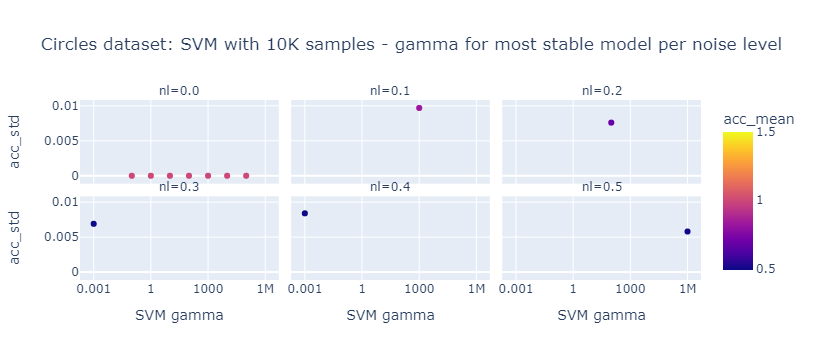

In [528]:
gamma_most_stable_per_nl_10K_df = circles_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_std == grp.acc_std.min()]).reset_index(drop=True)
px.scatter(gamma_most_stable_per_nl_10K_df, x='svm_gamma', labels = {'svm_gamma': 'SVM gamma'}, y='acc_std', 
           log_x=True,
           color = 'acc_mean',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Circles dataset: SVM with 10K samples - gamma for most stable model per noise level")

For the Circles dataset, the model parameter (gamma) for most stable model is different for each noise level:
* nl = 0: any value of gamma between 0.1 and 100K delivers the highest stability level possible (0)
* nl = 0.1: gamma=1000,     min std is 0.0097
* nl = 0.2: gamma=100, min std is 0.0076
* nl = 0.3: gamma=0.001, min std is 0.0069
* nl = 0.4: gamma=0.001, min std is 0.0084
* nl = 0.5: gamma=1M, min std is 0.0058

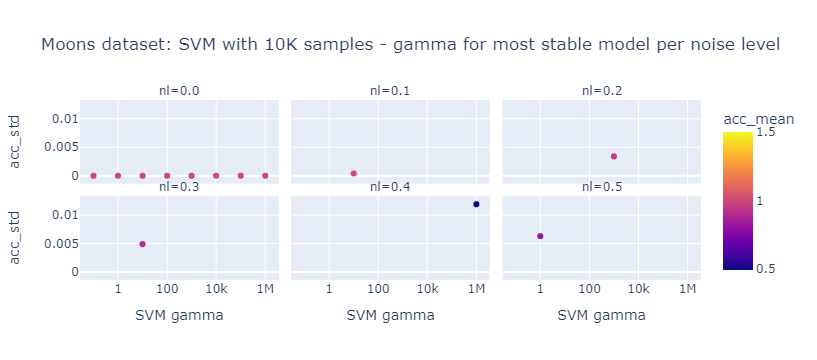

In [529]:
gamma_most_stable_per_nl_10K_df = moons_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_std == grp.acc_std.min()]).reset_index(drop=True)
px.scatter(gamma_most_stable_per_nl_10K_df, x='svm_gamma', labels = {'svm_gamma': 'SVM gamma'}, y='acc_std', 
           log_x=True,
           color = 'acc_mean',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Moons dataset: SVM with 10K samples - gamma for most stable model per noise level")

For the Moons dataset, the model parameter (gamma) for most stable model is different for each noise level:
* nl = 0: any value of gamma between 0.1 and 1M delivers the highest stability level possible (0)
* nl = 0.1: gamma=10,     min std is 0.0009
* nl = 0.2: gamma=1000, min std is 0.0034
* nl = 0.3: gamma=10, min std is 0.0049
* nl = 0.4: gamma=1M, min std is 0.0119
* nl = 0.5: gamma=1, min std is 0.0063

In [530]:
circles_log_reg_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 10000")
moons_log_reg_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 10000")

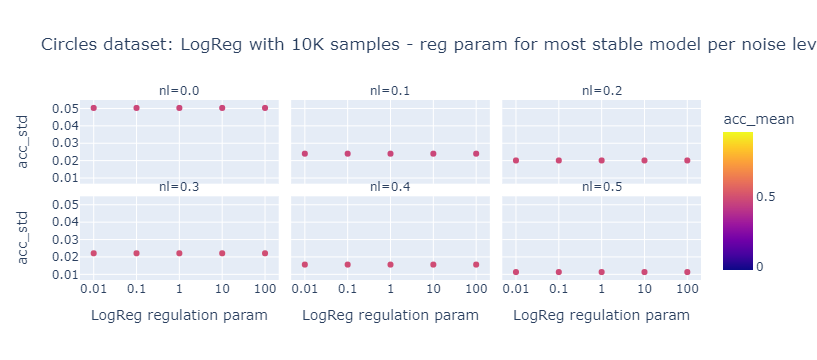

In [531]:
reg_param_most_stable_per_nl_10K_df = circles_log_reg_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_std == grp.acc_std.min()]).reset_index(drop=True)
px.scatter(reg_param_most_stable_per_nl_10K_df, x='reg', labels = {'reg': 'LogReg regulation param'}, y='acc_std', 
           log_x=True,
           color = 'acc_mean',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Circles dataset: LogReg with 10K samples - reg param for most stable model per noise level")

The value of the regulation parameter does not affect the stability (and hardly the accuracy level...) of the model in any of the noise levels:
- nl=0:   the standard deviation is 0.022 for no matter what the value of the regulation parameter is
- nl=0.1: the standard deviation is 0.028 for no matter what the value of the regulation parameter is
- nl=0.2: the standard deviation is 0.022 for no matter what the value of the regulation parameter is
- nl=0.3: the standard deviation is 0.020 for no matter what the value of the regulation parameter is
- nl=0.4: the standard deviation is 0.012 for no matter what the value of the regulation parameter is
- nl=0.5: the standard deviation is 0.019 for no matter what the value of the regulation parameter is
<br>The accuracy level is below 0.5 which is poor.

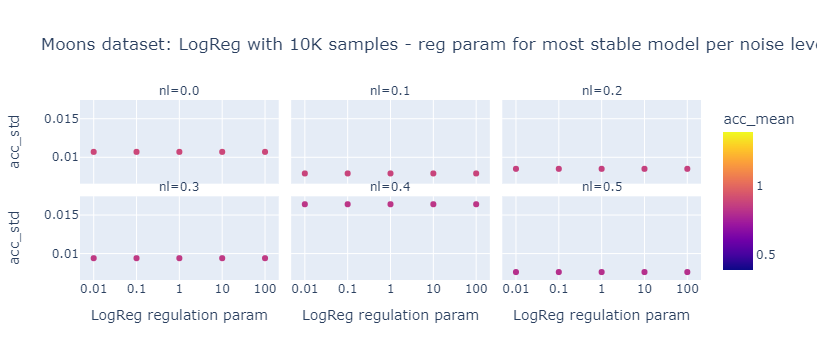

In [284]:
reg_param_most_stable_per_nl_10K_df = moons_log_reg_df.groupby(['nl']).apply(lambda grp: grp[grp.acc_std == grp.acc_std.min()]).reset_index(drop=True)
px.scatter(reg_param_most_stable_per_nl_10K_df, x='reg', labels = {'reg': 'LogReg regulation param'}, y='acc_std', 
           log_x=True,
           color = 'acc_mean',
           facet_col = 'nl', facet_col_wrap = 3,
           title="Moons dataset: LogReg with 10K samples - reg param for most stable model per noise level")

Also for the Moons dataset, the value of the regulation parameter does not affect the stability of the model in any of the noise levels:
- nl=0:   the standard deviation is 0.0044 for no matter what the value of the regulation parameter is
- nl=0.1: the standard deviation is 0.010 for no matter what the value of the regulation parameter is
- nl=0.2: the standard deviation is 0.009 for no matter what the value of the regulation parameter is
- nl=0.3: the standard deviation is 0.011 for no matter what the value of the regulation parameter is
- nl=0.4: the standard deviation is 0.006 for no matter what the value of the regulation parameter is
- nl=0.5: the standard deviation is 0.011 for no matter what the value of the regulation parameter is
<br> The accuracy level is between 0.8 and 0.9 which is not that bad.

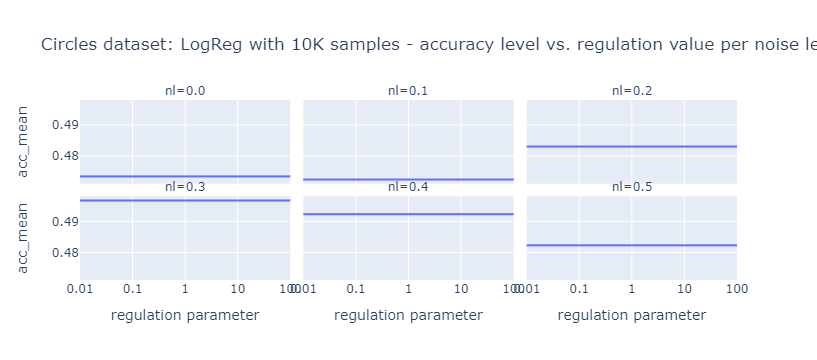

In [285]:
log_reg_10k_df = circles_log_reg_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.line(log_reg_10k_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 10K samples - accuracy level vs. regulation value per noise level")

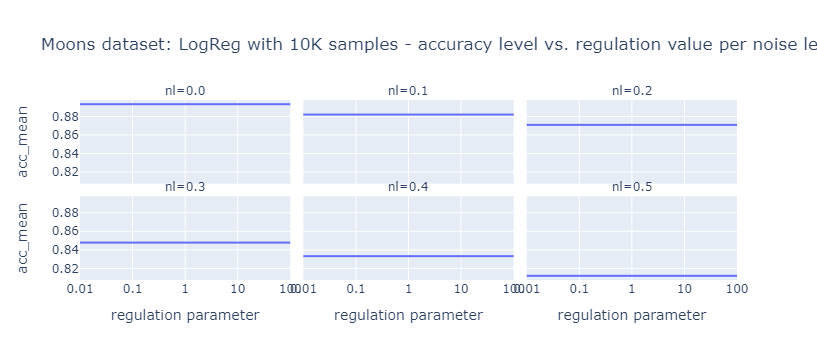

In [286]:
log_reg_10k_df = moons_log_reg_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
px.line(log_reg_10k_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Moons dataset: LogReg with 10K samples - accuracy level vs. regulation value per noise level")

#### 3. Does regularization help for linear models? consider different datasets sizes. 

In [287]:
circles_log_reg_10_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 10")
circles_log_reg_50_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 50")
circles_log_reg_100_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 100")
circles_log_reg_1000_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 1000")
circles_log_reg_10000_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg' & n == 10000")
moons_log_reg_10_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 10")
moons_log_reg_50_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 50")
moons_log_reg_100_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 100")
moons_log_reg_1000_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 1000")
moons_log_reg_10000_df = results_df.query("dataset_name == 'moons' & clf == 'log_reg' & n == 10000")

In [288]:
log_reg_10_df = circles_log_reg_10_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
log_reg_50_df = circles_log_reg_50_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
log_reg_100_df = circles_log_reg_100_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
log_reg_1000_df = circles_log_reg_1000_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)
log_reg_10000_df = circles_log_reg_10000_df.groupby(['nl', 'reg']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()]).reset_index(drop=True)

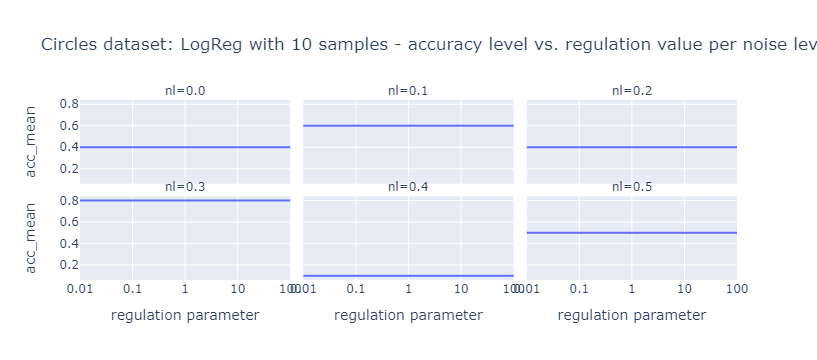

In [532]:
px.line(log_reg_10_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 10 samples - accuracy level vs. regulation value per noise level")

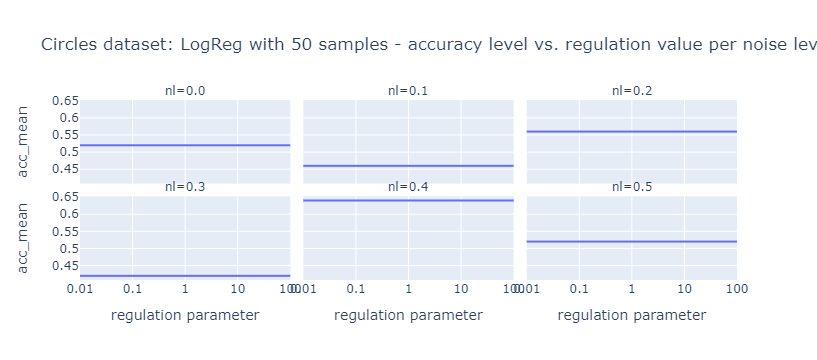

In [290]:
px.line(log_reg_50_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 50 samples - accuracy level vs. regulation value per noise level")

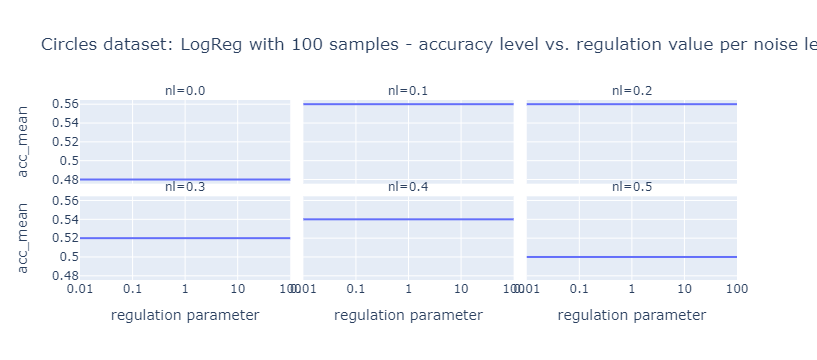

In [291]:
px.line(log_reg_100_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 100 samples - accuracy level vs. regulation value per noise level")

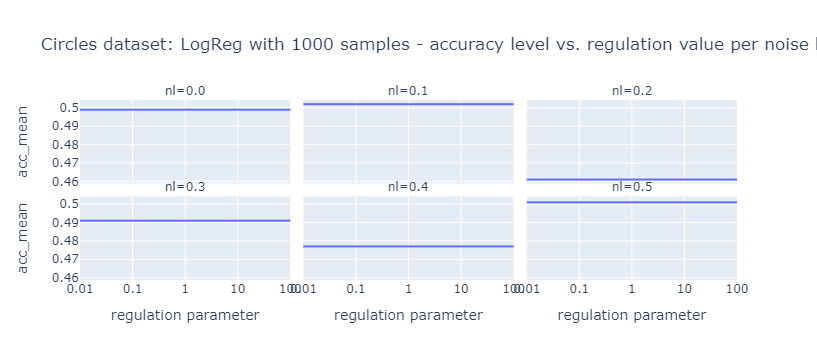

In [292]:
px.line(log_reg_1000_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 1000 samples - accuracy level vs. regulation value per noise level")

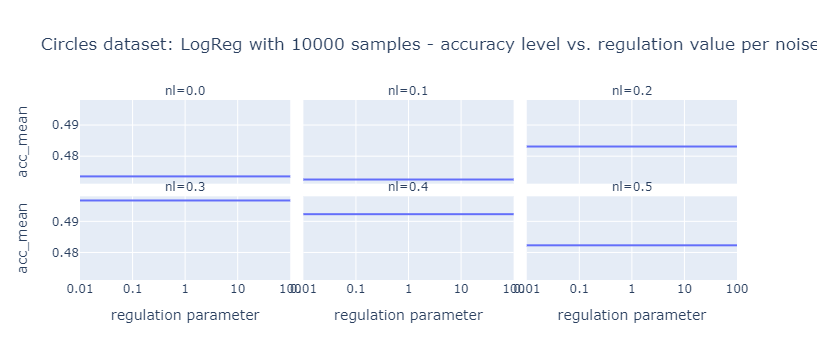

In [293]:
px.line(log_reg_10000_df, x='reg', labels = {'reg': 'regulation parameter'}, y='acc_mean', 
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg with 10000 samples - accuracy level vs. regulation value per noise level")

The regulation does not help the linear model...the accuracy level remains the same per noise level no matter what the regulation value is. This is true for both Circles and Moons datasets.

#### 4. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? (answer for svm and LR seperatly)

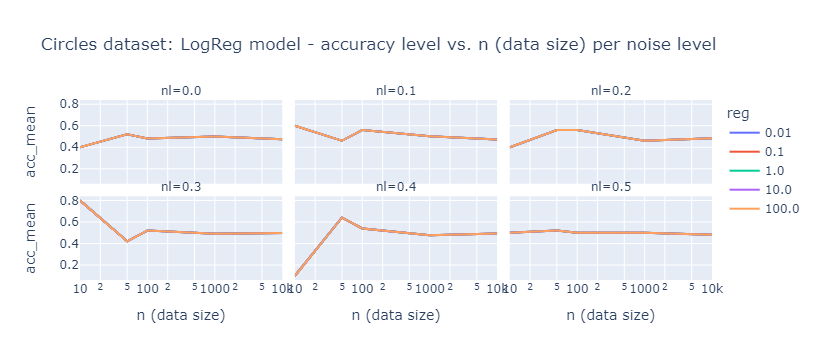

In [294]:
circles_log_reg_df = results_df.query("dataset_name == 'circles' & clf == 'log_reg'")
px.line(circles_log_reg_df, x='n', labels = {'n': 'n (data size)'}, y='acc_mean', 
        color = 'reg',
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: LogReg model - accuracy level vs. n (data size) per noise level")

Choosing nl@0.1, the accuracy level of the LogReg classifier initially goes down with data size, then increases and eventually falls to near minimum level.  

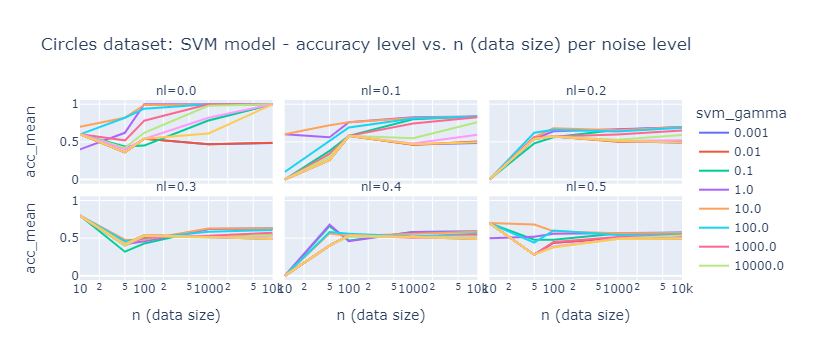

In [295]:
circles_svm_df = results_df.query("dataset_name == 'circles' & clf == 'svm'")
px.line(circles_svm_df, x='n', labels = {'n': 'n (data size)'}, y='acc_mean', 
        color = 'svm_gamma',
        facet_col='nl', facet_col_wrap=3,
        log_x=True, 
        title="Circles dataset: SVM model - accuracy level vs. n (data size) per noise level")

For the SVM model, the value of the hyper parameter gamma strongly affects the accuracy level with low noise levels and we can see that accuracy increases with data size under low noise circmustances while it is actually decreasing when noise levels are very high e.g. 0.4 and 0.5.
<br><br>
Generally we can see that for gamma==1, data size larger than 1000 does not improve the performance/accuracy of the clasiffier.

#### 5. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? (answer for svm and LR seperatly)

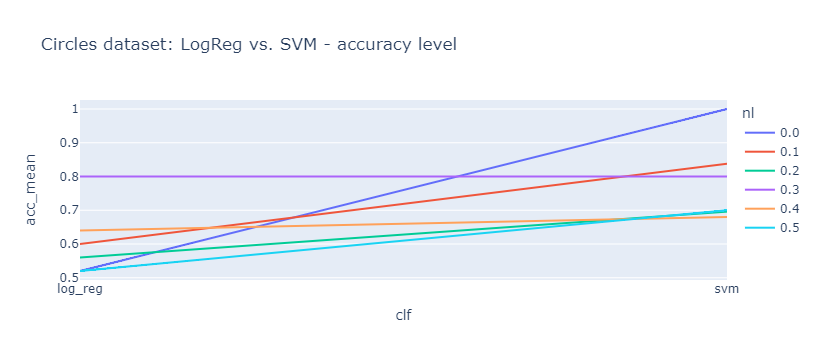

In [296]:
circles_nl_df = results_df.query("dataset_name == 'circles'")
circles_nl_df = circles_nl_df.groupby(['nl', 'clf']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()])\
.reset_index(drop=True)

px.line(circles_nl_df, x='clf', y='acc_mean', 
        color = 'nl',
        title="Circles dataset: LogReg vs. SVM - accuracy level")

From the plot above, we can see that for any noise level we choose, the more complex model SVM model delivers higher accuracy level than the simpler Logistic Regression model.

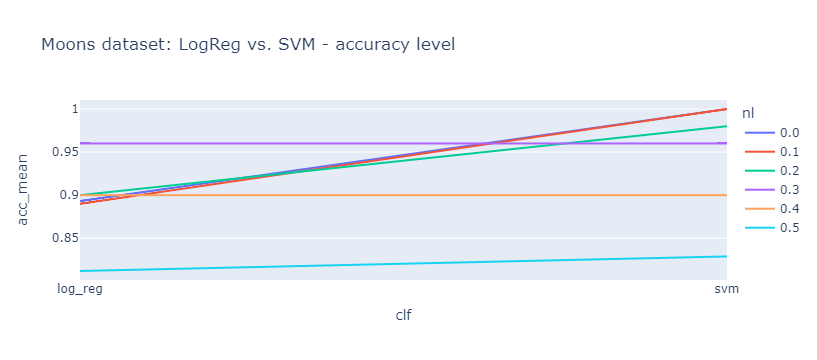

In [297]:
moons_nl_df = results_df.query("dataset_name == 'moons'")
moons_nl_df = moons_nl_df.groupby(['nl', 'clf']).apply(lambda grp: grp[grp.acc_mean == grp.acc_mean.max()])\
.reset_index(drop=True)

px.line(moons_nl_df, x='clf', y='acc_mean', 
        color = 'nl',
        title="Moons dataset: LogReg vs. SVM - accuracy level")

From the plot above, we can see that also for the Moons dataset, for any noise level we choose, the more complex model SVM model delivers higher accuracy level than the simpler Logistic Regression model although to a much lesser degree than we saw with the Circles dataset.

#### 6. Are the noise level effect the number of datapoints needed to reach optimal test results? 

For the SVM model:<br>Yes, The noise level does affect the number of datapoints required to reach optimal test results. With low noise levels (0 and 0.1) the greater the number of datapoints, the more optimal the accuracy level becomes while with high noise levels (0.2-0.5), more datapoints actually degrade the performance of the models.
<br><br>
For the LogReg model:<br> Yes, like with the SVM model, the noise level does affect the number of datapoints required to reach optimal test results, however, in a less consistent pattern. With some noise levels (0.1, 0.3 and 0.4) the accuracy level increases with datasize of 10, 50 and 100 and then decreases with 1000 and 10000 data points, while with other noise levels (0, 0.2 and 0.5), the greater the data size the poorer the accuracy. 

#### Bonus:

* For SVM: Select one dataset and with 0.2 noise level. Identify the optimal model params, and visualize the decision boundry learned. 
  * Hint: Use a grid. See classification models notebook 

In [305]:
#Selecting the Circles dataset with 0.2 noise level:
bonus_df = results_df.query("dataset_name == 'circles' & nl == 0.2")

In [318]:
#Identifying the optimal model gamma param (the model that yielded the highest accuracy):
optimal_svm_gamma = bonus_df[bonus_df.acc_mean == bonus_df.acc_mean.max()].svm_gamma.max()
print(f'The optimal model params are: C=1, gamma = {optimal_svm_gamma}')

The optimal model params are: C=1, gamma = 0.1


In [490]:
#Retrieving the Circles data for noise level 0.2
bonus_circles_df = all_circles_df[2][['x', 'y', 'label']]

In [505]:
X = bonus_circles_df.iloc[:, :2].to_numpy()  # assigning the two features (x, y) to X
y = bonus_circles_df.label.map({'A':0, 'B': 1}).to_numpy()  #assigning the label to y

In [506]:
#Preparing a grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

In [507]:
#Fitting the optimal SVC model to the Circles data 
clf = SVC(C=1, gamma=optimal_svm_gamma).fit(X, y)

In [508]:
#Predicting for all the grid data
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

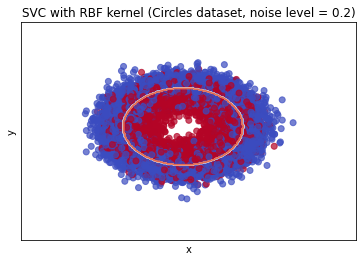

In [509]:
# Plot the decision boundary 
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=1)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVC with RBF kernel (Circles dataset, noise level = 0.2)')

plt.show()

In [497]:
# Now for the Moons data...
#Retrieving the Moons data for noise level 0.2
bonus_moons_df = all_moons_df[2][['x', 'y', 'label']]

In [499]:
X = bonus_moons_df.iloc[:, :2].to_numpy()  # assigning the two features (x, y) to X
y = bonus_moons_df.label.map({'A':0, 'B': 1}).to_numpy()  #assigning the label to y

In [500]:
#Fitting the optimal SVC model to the Circles data 
clf = SVC(C=1, gamma=optimal_svm_gamma).fit(X, y)

In [501]:
#Predicting for all the grid data
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

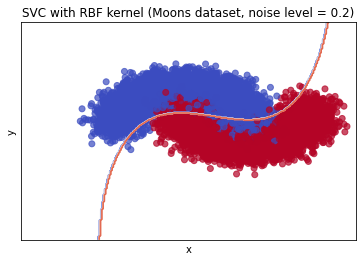

In [504]:
# Plot the decision boundary 
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=1)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVC with RBF kernel (Moons dataset, noise level = 0.2)')

plt.show()

## Tips and Hints

For buliding the experiment:

* Start with one dataframe holding all the data for both datastes with different noise level. Use the `make_<dataset_name>_dataframe()` functions below, and add two columns, dataset_name and noise_level, before appending the new dataset to the rest of the datasets. Use `df = pd.DataFrame()` to start with an empty dataframe and using a loop, add data to it using `df = df.append(<the needed df here>)`. Verify that you have 10k samples for each dataset type and noise level by a proper `.value_counts()`. You can modify the 
* When you'll need an N samples data with a specific noise level, use `query()` and `head(n)` to get the needed dataset. 
* Use sklearn `train_test_split()` method to split the data with `test_size` and `random_state` parameters set correctly to ensure you are always splitting the data the same why for a given fold `k`. Read [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if needed. 
* You can also not create your own data splitter, and instead use `model_selection.cross_validate()` from sklearn. You'll need to ask for the train erros as well as the test errors, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).
* Use prints in proper location to ensure the progress of the experiment. 

**If you get stuck, and need refernce, scroll to the end of the notebook to see more hints!**

## Moons dataset

In [17]:
from sklearn.datasets import make_moons

In [18]:
moons_df = make_moons_dataframe(n_samples=1000, noise_level=0.1)
moons_df.head()

,x,y,label
0,2.069251,0.340605,B
1,0.300955,0.915131,A
2,0.455557,-0.481645,B
3,-0.818138,0.334844,A
4,1.843128,0.121671,B


In [19]:
@widgets.interact
def plot_noisy_moons(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    moons_df = make_moons_dataframe(n_samples=1000, noise_level=noise_level)
    return px.scatter(moons_df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

## Circles Dataset

In [20]:
circles_df = make_circles_dataframe(n_samples=500, noise_level=0)
circles_df.head()

,x,y,label
0,0.763892,0.237633,B
1,0.994951,0.100362,A
2,-0.728085,0.331500,B
3,0.658826,-0.453815,B
4,0.795961,-0.080289,B


In [21]:
@widgets.interact
def plot_noisy_circles(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    df = make_circles_dataframe(1000, noise_level)
    return px.scatter(df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

## Appendix

### More hints!

If you'll build the datasets dataframe correctly, you'll have **one** dataframe that has dataset_name and noise_level colmuns, as well as the regular x,y,label colmns. To unsure you've appended everything correctly, groupby the proper colmuns and look at the size:

In [22]:
# Use proper groupby statement to ensure the datasets dataframe contains data as expected. You should see the following result:

Your 

You experiment code should look something like that:

In [23]:
datasets_type = ['circles', 'moons']
k_folds = 10
n_samples = [10, 50, 100, 1000, 10000]
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
clf_types = ['log_reg', 'svm']
hp_range = <'Your hyper parameters ranges here'>
regularization_values = <'Your regularization values here'>
results = []
for ds_type in datasets_type:
    print(f'Working on {ds_type}')
    for nl in noise_levels:
        for n in n_samples:
            ds = datasets.query(<'your query here'>).head(n)
            print(f'Starting {k_folds}-fold cross validation for {ds_type} datasets with {n} samples and noise level {nl}. Going to train {clf_types} classifiers.')
            for k in range(k_folds):
                X, Y = <'Your code here'>
                x_train,x_test,y_train,y_test= <'Your code here'>
                for clf_type in clf_types:
                    if clf_type == 'log_reg':
                        for regularization_value in regularization_values:
                            train_acc, test_acc = <'Your code here'>
                            results.append(<'Your code here'>)
                    if clf_type == 'svm':
                        for gamma in hp_range:
                            train_acc, test_acc = <'Your code here'>
                            results.append(<'Your code here'>)

SyntaxError: invalid syntax (Temp/ipykernel_24496/3386946450.py, line 6)

### Question 1 - Manual Classification

The purpose of this excercise is to examplify the need in a fitting algorithm. We will do so by trying to find only 2 models parameters by ourselves. 

In [ ]:
slope, intercept = 2.5, 6

In [ ]:
x_1, x_2 = 0.2, 0.6
on_line = [[x, x*slope + intercept,'on_line'] for x in np.linspace(-1,2,100)]

above_line = [[x_1, x_1*slope + intercept + 2, 'Above'], 
              [x_2, x_2*slope + intercept + 2, 'Above']] 

below_line = [[x_1, x_1*slope + intercept - 2, 'Below'], 
              [x_2, x_2*slope + intercept - 2, 'Below']] 

In [ ]:
columns = ['x','y','label']
data = pd.DataFrame(on_line + above_line + below_line, columns = columns)

In [ ]:
px.scatter(data, x='x', y='y', color = 'label')